# Harmful Algal Bloom (HAB) Detection from Wyvern hyperspectral imagery, Exploratory Data Analysis (EDA)

- Normalized Difference Water Index (NDWI) -> water mask
- Normalized Difference Chlorophyll Index (NDCI)
- Make Blue Green Algae Index (BGI) aka Custom Phycocyanin Detection Index

## Band selection

###  Normalized Difference Water Index (NDWI)

The original NDWI as proposed by McFeeters (1996) used the following bands:

- Green: ~550 nm
- NIR: ~820-860 nm (typically Landsat NIR band)

Band selection for this notebook's NDWI:

- Green: Band 9 (550 nm)
- NIR: Band 30 (849 nm)

Formula: `NDWI = (green_r550 - nir_r849) / (green_r550 + nir_r849)`

### Normalized Difference Chlorophyll Index (NDCI)

> For the NDCI calculation, the band selection is quite specific and should focus on particular spectral features related to chlorophyll absorption and reflection. Let me explain the optimal choices:

> For R_RED, I recommend Band 17 (669 nm) because:
>    - This wavelength sits right in the chlorophyll-a absorption maximum (~670 nm)
>    - It captures the deepest part of the absorption trough in the red spectrum for phytoplankton
>    - The narrow FWHM (23.415 nm) provides precise measurement of this absorption feature

> For R_NIR, I recommend Band 21 (712 nm) instead of Band 31 (869 nm) because:
> - The 712 nm band captures the critical "red edge" position where reflectance increases sharply after chlorophyll absorption
> - This specific wavelength is sensitive to changes in chlorophyll concentration
> - Most NDCI implementations use bands around 700-720 nm rather than longer NIR wavelengths

Source: Claude 3.7

Band selection for this notebook's NDCI:

- Red: Band 9 (550 nm)
- NIR: Band 30 (849 nm)

### Blue Green Algae Index (BGI) aka Custom Phycocyanin Detection Index (CPDI)

The BGA-Index often uses:

A band near 620-630 nm (phycocyanin absorption peak)
A reference band near 600 nm and/or 650 nm

Recommended bands from your data:

Primary band: Band 13 (614 nm) - closest to the phycocyanin absorption feature
Reference band 1: Band 12 (600 nm)

CPDI = (R614 - R600) / (R600 + R634)

Where R refers to reflectance at the specified wavelength.

This formulation identifies the absorption trough at around 620 nm (approximated by your 614 nm band) relative to the neighboring wavelengths, which is characteristic of phycocyanin pigment in blue-green algae.


## Wyvern Hyperspectral Band Information Table

Enhanced output of `gdalinfo wyvern_dragonette-003_20241229T165203_12324bcb.tiff`

| Band ID | Wavelength (nm) | Color/Name |
|---------|----------------|------------|
| 1 | 445 | Dark Blue (Violet-Blue) |
| 2 | 464 | Blue |
| 3 | 480 | Light Blue |
| 4 | 490 | Cyan-Blue |
| 5 | 503 | Blue-Green |
| 6 | 510 | Cyan |
| 7 | 519 | Cyan-Green |
| 8 | 534 | Light Green |
| 9 | 550 | Green |
| 10 | 569 | Yellow-Green |
| 11 | 585 | Yellow |
| 12 | 600 | Yellow-Orange |
| 13 | 614 | Orange |
| 14 | 634 | Orange-Red |
| 15 | 650 | Red |
| 16 | 659 | Red |
| 17 | 669 | Dark Red |
| 18 | 679 | Deep Red |
| 19 | 689 | Far Red |
| 20 | 700 | Red Edge |
| 21 | 712 | Red Edge |
| 22 | 722 | Red Edge |
| 23 | 734 | Near Infrared (NIR) |
| 24 | 749 | Near Infrared (NIR) |
| 25 | 764 | Near Infrared (NIR) |
| 26 | 781 | Near Infrared (NIR) |
| 27 | 799 | Near Infrared (NIR) |
| 28 | 814 | Near Infrared (NIR) |
| 29 | 832 | Near Infrared (NIR) |
| 30 | 849 | Near Infrared (NIR) |
| 31 | 869 | Near Infrared (NIR) |


Note: This table shows the electromagnetic spectrum transitions from visible light (approximately 400-700nm) into the near-infrared region. The "Red Edge" represents the transition zone between visible red and NIR, which is particularly important in vegetation analysis.

| Color | Wavelength Range (nm) | Peak Wavelength (nm) | Corresponding Bands |
|-------|-------------------|-------------------|-------------------|
| Blue | 450-495 | ~470 | Bands 1-3 (445-480 nm) |
| Green | 495-570 | ~530 | Bands 7-9 (519-550 nm) |
| Red | 620-700 | ~650 | Bands 14-16 (634-659 nm) |


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from rasterio.features import shapes
from shapely.geometry import shape, mapping
import geopandas as gpd
from PIL import Image

In [ ]:
tampico_mx = "../wyvern_dragonette-003_20241229T165203_12324bcb.tiff"  # https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-003_20241229T165203_12324bcb/wyvern_dragonette-003_20241229T165203_12324bcb.tiff

tampico_mx_data_mask = "../wyvern_dragonette-003_20241229T165203_12324bcb_data_mask.tiff"  # https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-003_20241229T165203_12324bcb/wyvern_dragonette-003_20241229T165203_12324bcb_data_mask.tiff

overview_img = "https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-003_20241229T165203_12324bcb/wyvern_dragonette-003_20241229T165203_12324bcb_preview.png"

## Create visual scene preview (RGB bands) in Geotiff format

In [2]:
def make_visual_rgb(filename: str, red: np.ndarray, green: np.ndarray, blue: np.ndarray, profile, nodata: np.number) -> None:
    """
    Creates preview , with some normalization and removing outliers.
    """
    # Stack the bands to create RGB image
    # Make a copy of the input arrays to avoid modifying the originals
    result_arr = np.stack([np.copy(red), np.copy(green), np.copy(blue)], axis=0)
    result_arr[result_arr == nodata] = np.nan

    # Normalize each band to [0, 1] range for better visualization
    # This is important for hyperspectral data which may have varying ranges
    for i in range(3):
        band = result_arr[i]
        min_val = np.percentile(band[band > 0], 2)  # 2nd percentile to avoid outliers
        max_val = np.percentile(band[band > 0], 98)  # 98th percentile to avoid outliers
        result_arr[i] = np.clip((band - min_val) / (max_val - min_val), 0, 1)

    # Reshape from scientific to image format (bands, height, width) -> (height, width, bands)
    result_arr = np.transpose(result_arr, (1, 2, 0))

    with rio.open(
        filename,
        "w",
        driver="GTiff",
        height=result_arr.shape[0],
        width=result_arr.shape[1],
        count=3,
        dtype=result_arr.dtype,
        crs=profile["crs"],
        transform=profile["transform"],
    ) as dst:
        for i in range(3):
            dst.write(result_arr[:, :, i], i+1)

## Visualize Wyvern preview image for this scene (PNG)

Note there does not appear to be any cloud cover.

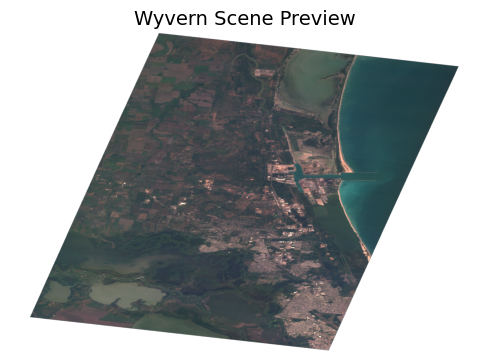

In [4]:
# Display the Wyvern preview image
response = requests.get(overview_img)
img = Image.open(BytesIO(response.content))

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("Wyvern Scene Preview", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## Read all the bands which will be used in the notebook

These are selected from the 31 available bands in the Wyvern hyperspectral imagery (See Band Selection above). Use Rasterio to read the bands into Numpy ndarrays.

In [5]:
with rio.open(tampico_mx) as src:

    # Blue 464nm for RGB preview
    band_blue_r464 = src.descriptions.index("Band_464")
    blue_r464 = src.read(band_blue_r464 + 1)

    # Green 550nm for NDWI and RGB preview
    band_green_r550 = src.descriptions.index("Band_550")
    green_r550 = src.read(band_green_r550 + 1)

    # Red 650nm for RGB preview
    band_red_r650 = src.descriptions.index("Band_650")
    red_r650 = src.read(band_red_r650 + 1)

    # Red 669nm for BGI, NDCI, FAI
    band_red_r669 = src.descriptions.index("Band_669")
    red_r669 = src.read(band_red_r669 + 1)

    # Red-Edge 700nm for BGI
    band_red_edge_r700 = src.descriptions.index("Band_700")
    red_edge_r700 = src.read(band_red_edge_r700 + 1)

    # NIR 712nm for NDCI
    band_nir_r712 = src.descriptions.index("Band_712")
    nir_r712 = src.read(band_nir_r712 + 1)

    # NIR 849nm for NDWI
    band_nir_r849 = src.descriptions.index("Band_849")
    nir_r849 = src.read(band_nir_r849 + 1)

    # NIR 869nm for BGI, FAI
    band_nir_r869 = src.descriptions.index("Band_869")
    nir_r869 = src.read(band_nir_r869 + 1)

    # save scene metadata
    profile = src.profile

    # confirm all the bands have same nodata value, so we can just use a common variable for all bands
    for i in range(0, 31):
        assert src.nodatavals[i] == src.nodatavals[0]
    nodata_val = src.nodatavals[0]

In [6]:
nodata_val

-9999.0

In [ ]:
make_visual_rgb(
    "wyvern_dragonette-003_20241229T165203_12324bcb_L1B.geotiff",
    red_r650,
    green_r550,
    blue_r464,
    profile,
    nodata_val
)

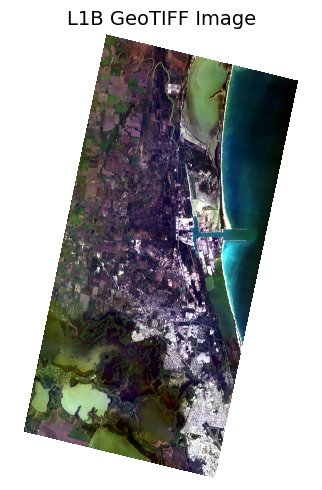

In [26]:
with rio.open("wyvern_dragonette-003_20241229T165203_12324bcb_L1B.geotiff") as l1b_src:
    l1b_image = np.transpose(l1b_src.read(), (1, 2, 0))  # Convert to (height, width, bands)

plt.figure(figsize=(5, 5))
plt.imshow(l1b_image)
plt.title("L1B GeoTIFF Image", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

## Make validity masks using NODATA values

Use numpy.NaN (not a number) for validity mask for simplicity.

In [27]:
blue_r464[blue_r464 == nodata_val] = np.nan
blue_r464_valid_mask = ~np.isnan(blue_r464)

green_r550[green_r550 == nodata_val] = np.nan
green_r550_valid_mask = ~np.isnan(green_r550)

red_r650[red_r650 == nodata_val] = np.nan
red_r650_valid_mask = ~np.isnan(red_r650)

red_r669[red_r669 == nodata_val] = np.nan
red_r669_valid_mask = ~np.isnan(red_r669)

red_edge_r700[red_edge_r700 == nodata_val] = np.nan
red_edge_r700_valid_mask = ~np.isnan(red_edge_r700)

nir_r712[nir_r712 == nodata_val] = np.nan
nir_r712_valid_mask = ~np.isnan(nir_r712)

nir_r849[nir_r849 == nodata_val] = np.nan
nir_r849_valid_mask = ~np.isnan(nir_r849)

nir_r869[nir_r869 == nodata_val] = np.nan
nir_r869_valid_mask = ~np.isnan(nir_r869)

## Visualize "cloud" mask and "clear" QA masks

Are there clouds which need to be masked out? Wyvern provides a side-car QA raster (`*_data_mask.tiff`).

In [12]:
with rio.open(tampico_mx_data_mask) as src:
    band_cloud_mask = src.descriptions.index("QA_CLOUD_MASK")
    band_clear_mask =src.descriptions.index("QA_CLEAR_MASK")
    cloud_mask = src.read(band_cloud_mask + 1)
    clear_mask = src.read(band_clear_mask + 1)

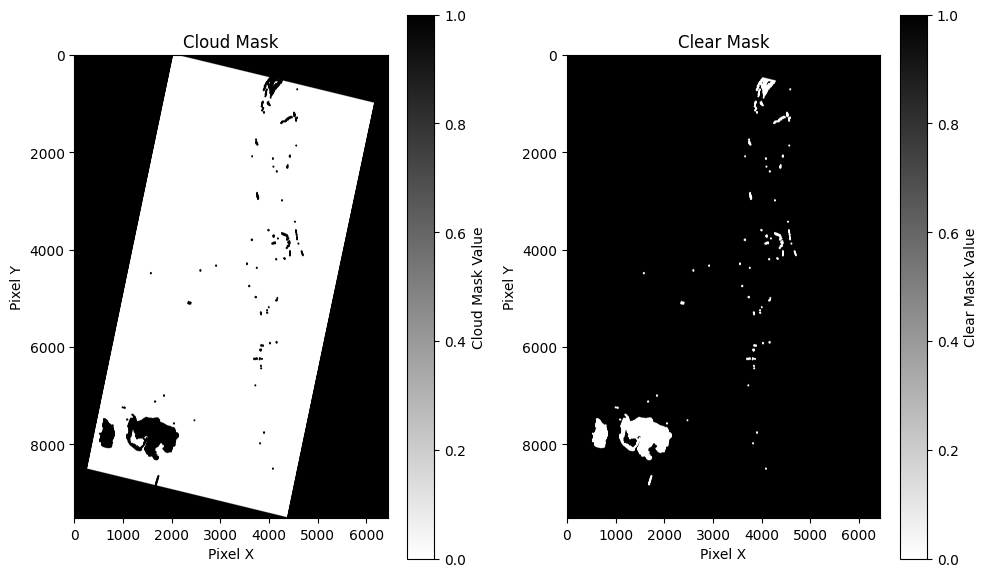

In [13]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(cloud_mask, cmap="binary", vmin=0, vmax=1)
plt.colorbar(label="Cloud Mask Value")
plt.title("Cloud Mask")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.subplot(1, 2, 2)
plt.imshow(clear_mask, cmap="binary", vmin=0, vmax=1)
plt.colorbar(label="Clear Mask Value")
plt.title("Clear Mask")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
plt.show()

## ⚠️ Architectural decision

Do not use the clear/cloud mask layers for this workflow. They don't seem accurate, or I cannot interpret then. When closely inspecting the preview image, it definitely appears to be a cloud free scene.

## Normalized Difference Water Index (NDWI)

The range is [0, 1] and interpretation is 1 = water and -1 = no water. Formula:

```
NWDI = (Green - NIR) / (Green + NIR)
```

### Visualize the Green and NIR bands

Preview of the raw reflectance before NDWI calculation.

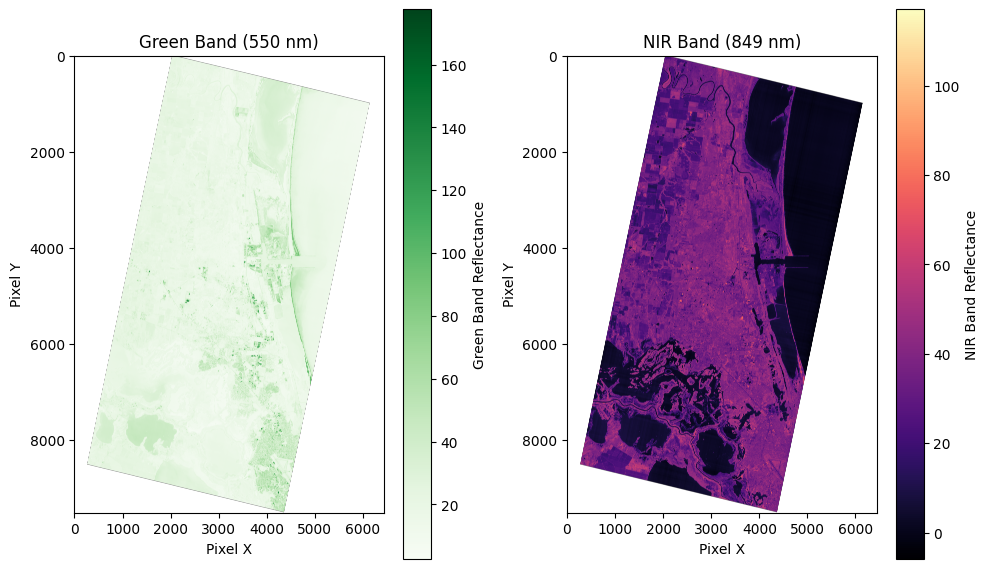

In [28]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(green_r550, cmap="Greens")
plt.colorbar(label="Green Band Reflectance")
plt.title("Green Band (550 nm)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.subplot(1, 2, 2)
plt.imshow(nir_r849, cmap="magma")
plt.colorbar(label="NIR Band Reflectance")
plt.title("NIR Band (849 nm)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
plt.show()

### Make NDWI

In [15]:
valid_mask = green_r550_valid_mask & nir_r849_valid_mask
ndwi = np.full_like(green_r550, np.nan)
ndwi[valid_mask] = (green_r550[valid_mask] - nir_r849[valid_mask]) / (green_r550[valid_mask] + nir_r849[valid_mask])

## Visualize NDWI raster

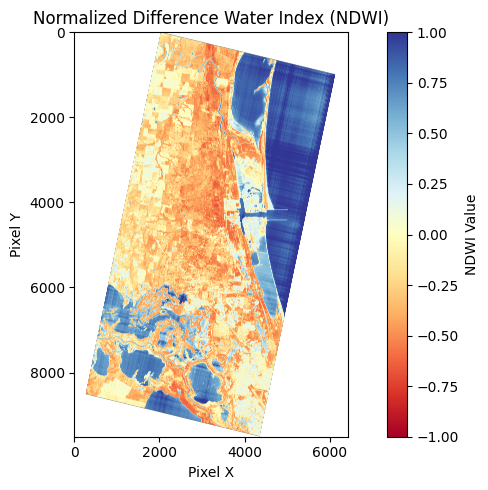

In [16]:
plt.figure(figsize=(8, 5))
plt.imshow(ndwi, cmap="RdYlBu", vmin=-1, vmax=1)
plt.colorbar(label="NDWI Value")
plt.title("Normalized Difference Water Index (NDWI)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.tight_layout()
plt.show()

## Make a water mask raster with threshold value

By convention with NDWI, water is `> 0.3`, but it's clear from the NDWI raster we have to threshold lower.

In [21]:
water_threshold = 0.3
water_mask = np.zeros_like(ndwi, dtype=bool)
water_mask[valid_mask] = ndwi[valid_mask] > water_threshold

## Visualize water mask

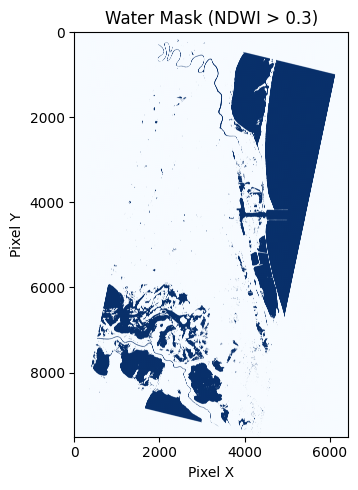

In [22]:
plt.figure(figsize=(8, 5))
plt.imshow(water_mask, cmap="Blues", vmin=0, vmax=1)
plt.title(f"Water Mask (NDWI > {water_threshold})")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.tight_layout()
plt.show()

### Polygonize the water mask area

Write to GeoJSON file.

In [29]:
results = (
    {"properties": {"value": v}, "geometry": s}
    for s, v in shapes(water_mask.astype(np.uint8), mask=water_mask, transform=profile["transform"])
)
geometries = [shape(result["geometry"]) for result in results if result["properties"]["value"] == 1]
gdf = gpd.GeoDataFrame(geometry=geometries, crs=profile["crs"])
gdf.to_file("water-mask.geojson", driver="GeoJSON")

In [ ]:
from ipyleaflet import Map, GeoJSON
import geopandas as gpd

# Load the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file("wyvern_dragonette-003_20241229T165203_12324bcb_water_mask.geojson")

# Create a map centered on the GeoDataFrame"s centroid
# If gdf has multiple polygons, find the centroid of the whole collection
bbox = gdf.total_bounds
center = ((bbox[0] + bbox[2])/2, (bbox[1] + bbox[3])/2)
map = Map(center=(center[1], center[0]), zoom=10)

# Add the GeoDataFrame as a GeoJSON layer
geo_json = GeoJSON(data=gdf.__geo_interface__)
map.add_layer(geo_json)

# Display the map
map

Map(center=[np.float64(22.463213332996514), np.float64(-97.92013125373485)], controls=(ZoomControl(options=['p…

In [32]:
with rio.open(
    "wyvern_dragonette-003_20241229T165203_12324bcb_water_mask.geotiff",
    "w",
    driver="GTiff",
    height=water_mask.shape[0],
    width=water_mask.shape[1],
    count=1,
    dtype="uint8",
    crs=profile["crs"],
    transform=profile["transform"],
    compress="lzw",
) as dst:
    dst.write(water_mask.astype("uint8"), 1)

## Blue-Green Algae Index (BGI)

$$
BGI = \frac{\text{Red\_Edge\_Band\_R700}}{\text{Red\_Band\_R669}} - 1
$$

> Why it's effective for HABs:
> - Directly targets cyanobacteria (blue-green algae), which are the most common cause of harmful algal blooms
> - Leverages the specific absorption features of phycocyanin (a pigment unique to cyanobacteria)
> - The 700nm/669nm ratio is particularly sensitive to cyanobacterial concentrations
> - Simple calculation that clearly differentiates cyanobacteria from other water features (Copilot)

### Range and Interpretation

> - Positive values: Indicate the presence of blue-green algae (cyanobacteria), as the reflectance in the Red-Edge Band (700 nm) is higher relative to the Red Band (669 nm). This is due to the specific absorption and scattering properties of cyanobacteria.

> - Negative or near-zero values: Suggest the absence of blue-green algae, as the reflectance in the Red Band (669 nm) dominates or is similar to the Red-Edge Band (700 nm). (Copilot)


### Visualize the Red Edge and NIR bands

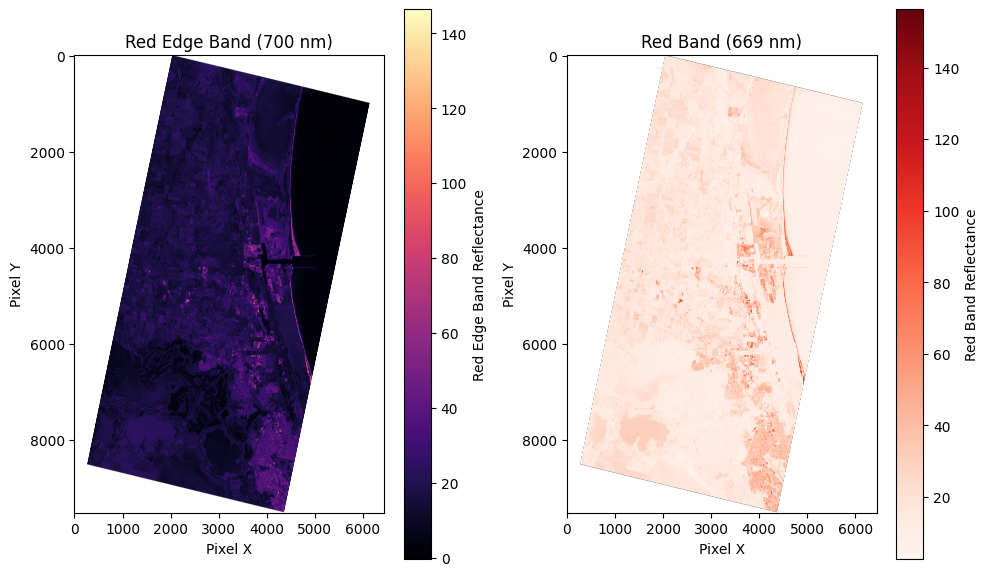

In [33]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(red_edge_r700, cmap="magma")
plt.colorbar(label="Red Edge Band Reflectance")
plt.title("Red Edge Band (700 nm)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.subplot(1, 2, 2)
plt.imshow(red_r669, cmap="Reds")
plt.colorbar(label="Red Band Reflectance")
plt.title("Red Band (669 nm)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
plt.show()

In [41]:
# BGI = (Red_Edge_Band_R700 / Red_Band_R669) - 1

valid_mask = red_edge_r700_valid_mask & red_r669_valid_mask & water_mask
bgi = np.full_like(red_edge_r700, np.nan)
bgi[valid_mask] = (red_edge_r700[valid_mask]  / red_r669[valid_mask]) - 1

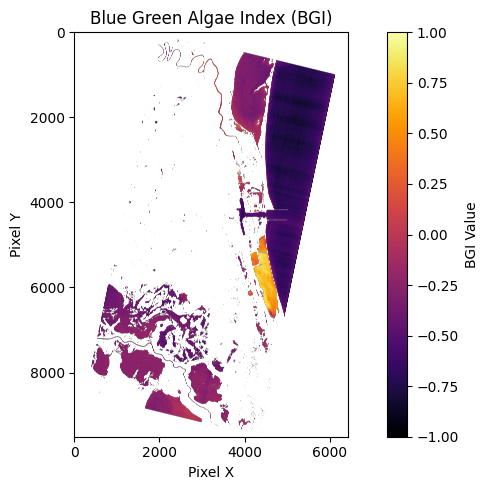

In [42]:
plt.figure(figsize=(8, 5))
plt.imshow(bgi, cmap="inferno", vmin=-1, vmax=1)
plt.colorbar(label="BGI Value")
plt.title("Blue Green Algae Index (BGI)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.tight_layout()
plt.show()

In [40]:
with rio.open(
    "wyvern_dragonette-003_20241229T165203_12324bcb_BGI.geotiff",
    "w",
    driver="GTiff",
    height=bgi.shape[0],
    width=bgi.shape[1],
    count=1,
    dtype="float32",
    crs=profile["crs"],
    transform=profile["transform"],
    compress="lzw",
) as dst:
    dst.write(bgi.astype("float32"), 1)

## Calculate Floating Algae Index (FAI)-like adaptation

Formula: `FAI_adapted = Band_869 - [Band_669 + (869-669)/(869-550) * (Band_550 - Band_669)]`

Why it's useful for HABs:

- Specifically designed to detect surface scum and floating algae mats
- Many harmful algal blooms form distinct surface accumulations
- Less affected by atmospheric interference than simple band ratios
- Good at distinguishing floating algae from suspended sediment

(source: Claude 3.7)

### TODO

## Calculate Normalized Difference Chlorophyll Index (NDCI)

Formula: `NDCI = (NIR_R712 - R_RED)/(NIR_R712 + R_RED)`

Why it works for HABs:

- Directly measures chlorophyll-a concentration, which increases during algal blooms
- The red-edge portion of the spectrum (712nm) is particularly sensitive to high chlorophyll levels
- Already implemented in your notebook and showing promising results


### Interpretation

Higher positive values (typically >0.2): Indicate higher chlorophyll concentration, suggesting the presence of algae in water bodies.



### Read Red and NIR bands

In [ ]:
with rio.open(tampico_mx) as src:
    band_id_red_r669 = src.descriptions.index("Band_669")
    band_id_nir_r712 = src.descriptions.index("Band_712")

    red_r669 = src.read(band_id_red_r669 + 1)
    nir_r712 = src.read(band_id_nir_r712 + 1)

    red_r669_nodata = src.nodatavals[band_id_red_r669]
    nir_r712_nodata = src.nodatavals[band_id_nir_r712]

    profile = src.profile

### Make validity mask using water mask, combined with NODATA values from red + nir bands.

In [ ]:
ndci_validity_mask = water_mask & red_r669_valid_mask & nir_r869_valid_mask
print(ndci_validity_mask.shape, ndci_validity_mask.dtype)

### Visualize the Red and NIR bands

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(red_r669, cmap="Reds")
plt.colorbar(label="Red Band Reflectance")
plt.title("Red Band (669 nm)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.subplot(1, 2, 2)
plt.imshow(nir_r869, cmap="magma")
plt.colorbar(label="NIR Band Reflectance")
plt.title("NIR Band (869 nm)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
plt.show()

### NDCI calculation

`NDCI = (R_NIR - R_RED)/(R_NIR + R_RED)`

In [ ]:
ndci = np.full_like(validity_mask, np.nan, dtype=np.float32)
ndci[ndci_validity_mask] = (nir_r869[ndci_validity_mask] - red_r669[ndci_validity_mask]) / (nir_r869[ndci_validity_mask] + red_r669[ndci_validity_mask])

### Visualize NDCI Raster

In [ ]:
plt.figure(figsize=(8, 5))
plt.imshow(ndci, cmap="magma", vmin=-1, vmax=1)
plt.colorbar(label="NDWI Value")
plt.title("Normalized Difference Chlorophyll Index (NDCI)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.tight_layout()
plt.show()

### Analysis

The northeast quadrant of the scene is open ocean, and it's displaying NDCI near 1.0, which seems incorrect. The cause is, apparently, because the NIR band has negative values. Clamp negative values to zero, this could be a calibration issue or noise?

In [ ]:
# Clamp NIR negative values to zero
nir_r712_clamped = np.copy(nir_r712)
nir_r712_clamped[nir_r712_clamped < 0] = 0

In [ ]:
ndci = np.full_like(validity_mask, np.nan, dtype=np.float32)
ndci[validity_mask] = (nir_r712_clamped[validity_mask] - red_r669[validity_mask]) / (nir_r712_clamped[validity_mask] + red_r669[validity_mask])

In [ ]:
plt.figure(figsize=(8, 5))
plt.imshow(ndci, cmap="magma", vmin=-1, vmax=1)
plt.colorbar(label="NDWI Value")
plt.title("Normalized Difference Chlorophyll Index (NDCI)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.tight_layout()
plt.show()

### Make preview image (PNG) of the NDCI raster

In [ ]:
# Convert NDCI array to a colorful image using the magma colormap
fig = plt.figure(figsize=(10, 8), frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

# Create the color mapping with the magma colormap, set vmin and vmax to control the color range
im = ax.imshow(ndci, cmap="magma", vmin=-1, vmax=1)

# Save the figure as PNG with high DPI for better quality
plt.savefig("ndci-colormap.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.close(fig)

# Add a version with colorbar for reference
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(ndci, cmap="magma", vmin=-1, vmax=1)
plt.colorbar(im, label="NDCI Value", ax=ax)
ax.set_title("Normalized Difference Chlorophyll Index (NDCI)")
ax.set_axis_off()
plt.savefig("ndci_colormap_with_legend.png", dpi=300, bbox_inches="tight")
plt.close(fig)

# Display the saved image
img = Image.open("ndci-colormap.png")
display(img)